In [1]:
import torch
from board import move
from board import create_action_mask
import torch.nn as nn
from torch.distributions.categorical import Categorical
import sys
from model import BoardGFLowNet
from board import random_board, get_reward, move, create_action_mask
import wandb



/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lr=1e-4
decoder_layers=3
encoder_layers=3
embed_dim=32
d_ff=16
n_heads=8
batch_size=512
side_len=3
max_steps=20
total_batches=1000
checkpoint_freq=10
gfn = BoardGFLowNet(side_len, embed_dim, d_ff, n_heads, encoder_layers, decoder_layers, 6)

In [3]:
#gfn.load_state_dict(torch.load('checkpoints/model_step_509.pt'))
gfn.eval()
''

''

In [4]:

def sample_move(boards: torch.Tensor, 
                logits: torch.Tensor, 
                at_step_limit: bool):
    
    batch_size, _, _ = boards.shape
    last_logits = logits[:, -1, :]
    
    if(at_step_limit):
        mask = torch.ones(6) * -1e20
        mask[1] = 0
        mask = mask.expand((batch_size, 6))
    else:
        mask = create_action_mask(boards)
    
    last_logits = torch.softmax(mask + last_logits, dim=1)
    new_moves = Categorical(probs=last_logits).sample()
    new_moves = torch.Tensor(new_moves).type(torch.LongTensor)
    return new_moves, last_logits[torch.arange(batch_size), new_moves]

In [5]:
sampled_rewards = []
sampled_matchings = []
with torch.no_grad():
    for i in range(10):
        boards = random_board(batch_size, side_len) 
        finished = torch.zeros((batch_size, 1))
        moves = torch.zeros(batch_size, 1).type(torch.LongTensor)
        forward_probabilities = torch.ones(batch_size, 1)

        predicted_logZ, _ = gfn(boards, moves)
        batch_loss = 0
        batch_reward = 0
        batch_matching = 0
        
        for i in range(max_steps):
            _, logits = gfn(boards, moves)
            new_move, move_prob = sample_move(boards, logits, i == max_steps-1)

            for index in range(len(move_prob)):
                if(finished[index] == 1):
                    move_prob[index] = 1
            for index, _move in enumerate(new_move):
                if(_move == 1):
                    finished[index] = 1

            forward_probabilities = torch.cat([forward_probabilities, move_prob.unsqueeze(1)], dim=1)
            moves = torch.cat([moves, new_move.unsqueeze(1)], dim=1)
            boards = boards.clone()
            boards = move(boards, new_move, finished_mask=finished)
        
        reward, matching = get_reward(boards)
        print(reward)
        sampled_rewards += reward.tolist()
        sampled_matchings += matching.tolist()
        reward = torch.sum(reward)
        matching = torch.sum(matching)
        batch_reward += reward
        batch_matching += matching
        batch_reward = batch_reward.item() / batch_size
        batch_matching = batch_matching.item() / batch_size
        

tensor([3.3546e-04, 1.2341e-04, 2.4788e-03, 9.1188e-04, 6.7379e-03, 2.4788e-03,
        2.4788e-03, 3.3546e-04, 3.3546e-04, 6.7379e-03, 3.3546e-04, 1.2341e-04,
        3.3546e-04, 3.3546e-04, 9.1188e-04, 1.2341e-04, 9.1188e-04, 1.2341e-04,
        4.9787e-02, 1.2341e-04, 2.4788e-03, 1.2341e-04, 9.1188e-04, 1.2341e-04,
        3.3546e-04, 4.9787e-02, 9.1188e-04, 9.1188e-04, 3.3546e-04, 3.3546e-04,
        9.1188e-04, 9.1188e-04, 2.4788e-03, 2.4788e-03, 1.8316e-02, 3.3546e-04,
        3.3546e-04, 9.1188e-04, 3.3546e-04, 1.2341e-04, 6.7379e-03, 6.7379e-03,
        1.2341e-04, 9.1188e-04, 9.1188e-04, 3.3546e-04, 6.7379e-03, 3.3546e-04,
        3.3546e-04, 3.3546e-04, 3.3546e-04, 9.1188e-04, 3.3546e-04, 1.2341e-04,
        9.1188e-04, 1.2341e-04, 2.4788e-03, 1.2341e-04, 1.2341e-04, 9.1188e-04,
        3.3546e-04, 1.2341e-04, 2.4788e-03, 3.3546e-04, 9.1188e-04, 2.4788e-03,
        3.3546e-04, 3.3546e-04, 3.3546e-04, 3.3546e-04, 1.2341e-04, 9.1188e-04,
        6.7379e-03, 1.2341e-04, 1.2341e-

In [7]:
import matplotlib.pyplot as plt

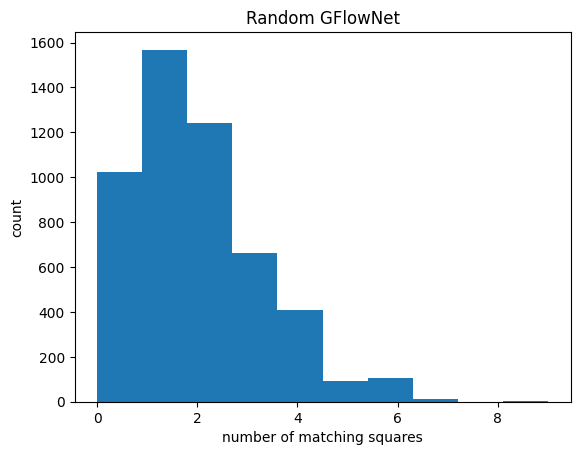

In [14]:
plt.hist(sampled_matchings)

plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Random GFlowNet')
import numpy as np

In [10]:
a = torch.load('sampled_matchings.pt')

Text(0.5, 1.0, 'Trained GFlowNet')

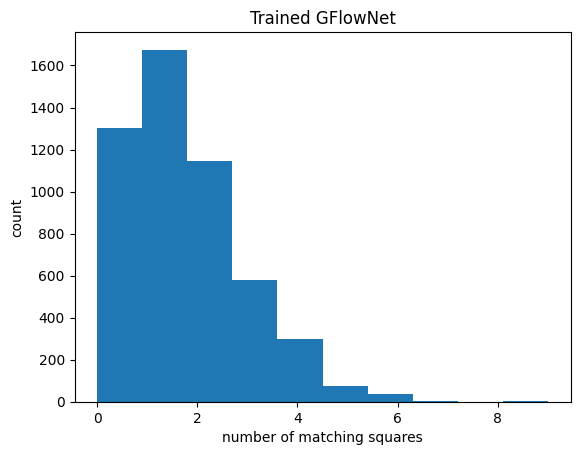

In [13]:
plt.hist(a)
plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained GFlowNet')

In [92]:
'''torch.save(sampled_matchings, 'sampled_matchings.pt')
torch.save(sampled_rewards, 'sampled_rewards.pt')'''

"torch.save(sampled_matchings, 'sampled_matchings.pt')\ntorch.save(sampled_rewards, 'sampled_rewards.pt')"